### Business Analysis

This notebook provides steps a business analysit might take to determine which customers are likely to churn. The intention is to compare these analyst prediction to the predictions of a machine learning algorithm for the same data set.

In [1]:
import pandas as pd
import io
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# # import the telco data as a pandas dataframe
# url = "https://raw.githubusercontent.com/navdeep-G/customer-churn/master/data/TelcoChurn.csv"
# content = requests.get(url).content
# telco_df = pd.read_csv(io.StringIO(content.decode('utf-8')))
telco_df = pd.read_csv('/Users/laurend/Code/repos/customer-churn/data/TelcoChurn.csv')

In [127]:
# get the dataframe dimensions
telco_df.shape

(7043, 21)

In [226]:
# get the type of each column
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7032 non-null float64
Churn               7043 non-null object
count               7043 non-nul

In [2]:
# get a list of the column names
for col in telco_df.columns:
    print col

customerID
gender
SeniorCitizen
Partner
Dependents
tenure
PhoneService
MultipleLines
InternetService
OnlineSecurity
OnlineBackup
DeviceProtection
TechSupport
StreamingTV
StreamingMovies
Contract
PaperlessBilling
PaymentMethod
MonthlyCharges
TotalCharges
Churn


In [110]:
# get a list of the column names
column_names = telco_df.columns
feature_list = column_names.drop("customerID")

# get number of unique values and types of each column
for col in column_names:
    print(col, telco_df[col].nunique())
    if telco_df[col].nunique() < 5:
        #print(col, telco_df[col].unique())
        None

('customerID', 7043)
('gender', 2)
('SeniorCitizen', 2)
('Partner', 2)
('Dependents', 2)
('tenure', 73)
('PhoneService', 2)
('MultipleLines', 3)
('InternetService', 3)
('OnlineSecurity', 3)
('OnlineBackup', 3)
('DeviceProtection', 3)
('TechSupport', 3)
('StreamingTV', 3)
('StreamingMovies', 3)
('Contract', 3)
('PaperlessBilling', 2)
('PaymentMethod', 4)
('MonthlyCharges', 1585)
('TotalCharges', 6530)
('Churn', 2)


In [4]:
# convert all numeric string columns to floats
# if there is an empty string coerce that to an NA
telco_df["MonthlyCharges"] = pd.to_numeric(telco_df["MonthlyCharges"], errors = 'coerce')
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce')

# check for missing values in each column
for col in column_names:
    if telco_df[col].isnull().sum() > 0:
        print('number of missing values {0} is {1}'.format(col,telco_df[col].isnull().sum()))

number of missing values TotalCharges is 11


In [22]:
# get a sense of the unique types of monthly charges, by rounding floats to integers
feature_data = telco_df["MonthlyCharges"]
print('max:',max(feature_data))
print('min:', min(feature_data))
# round the monthly charges to get a sense of how many unique monthly charges there are
int_feature = feature_data.apply(int)
unique_charges = int_feature .nunique()
print(int_feature .nunique()) 

('max:', 118.75)
('min:', 18.25)
99


('max:', 8684)
('min:', 0)


(array([ 1192.,   573.,   447.,   356.,   336.,   313.,   314.,   251.,
          227.]),
 array([   0,  200,  400,  600,  800, 1000, 1200, 1400, 1600, 1800]),
 <a list of 9 Patch objects>)

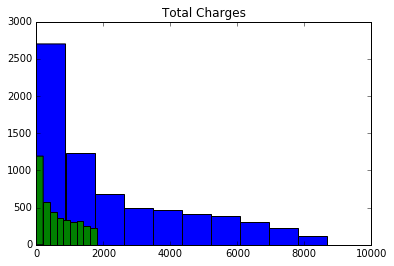

In [51]:
# creat bins for monthly and total charges, based off the min and max and then create a histogram
# replace na values with 0 for the Total Charges which has 11 missing values (these can be calcalted and filled later)
feature_data = telco_df["TotalCharges"].fillna(0)
int_feature = feature_data.apply(int)
print('max:',int(max(feature_data)))
print('min:', int(min(feature_data)))
max_feature = int(max(feature_data))
min_feature = int(min(feature_data))
num_of_bins = 10
binwidth =  (max_feature - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, max_feature + binwidth, binwidth))
plt.title("Total Charges")

# focus on the lower end of total changes, limit to the max value where there is drop off plateaus
set_max_value = 2000
num_of_bins = 10
binwidth =  (set_max_value - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, set_max_value, binwidth))

('max:', 118)
('min:', 18)


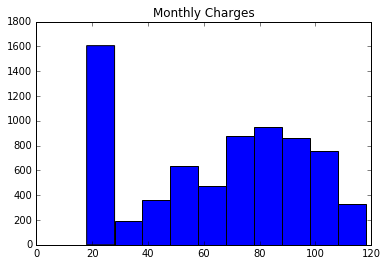

In [50]:
# creat bins for monthly and total charges, based off the min and max and then create a histogram
# replace na values with 0 for the Total Charges which has 11 missing values (these can be calcalted and filled later)
feature_data = telco_df["MonthlyCharges"]
int_feature = feature_data.apply(int)
print('max:',int(max(feature_data)))
print('min:', int(min(feature_data)))
max_feature = int(max(feature_data))
min_feature = int(min(feature_data))
num_of_bins = 10
binwidth =  (max_feature - min_feature)/num_of_bins
plt.hist(int_feature, bins=range(min_feature, max_feature + binwidth, binwidth))
plt.title("Monthly Charges")
# # focus on the lower end of total changes, limit to the max value where there is drop off plateaus
# set_max_value = 2000
# num_of_bins = 10
# binwidth =  (set_max_value - min_feature)/num_of_bins
# plt.hist(int_feature, bins=range(min_feature, set_max_value, binwidth))

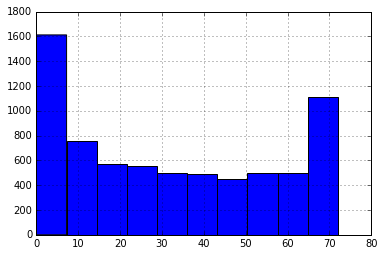

In [113]:
# get histogram of tenure (how long a person has been a customer in months)
telco_df['tenure'].hist()

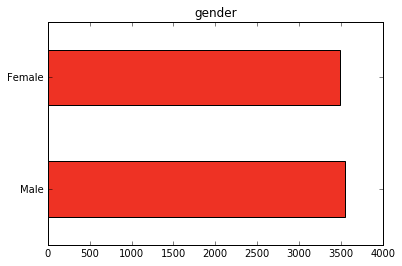

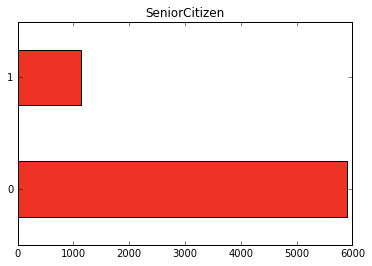

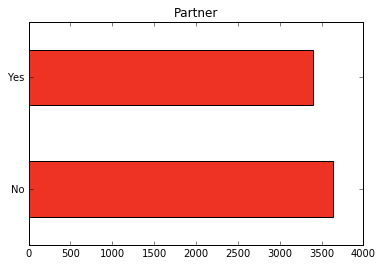

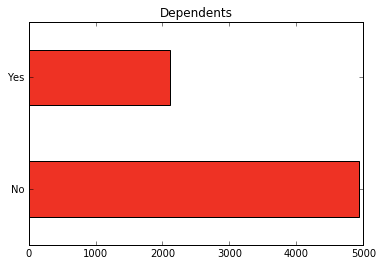

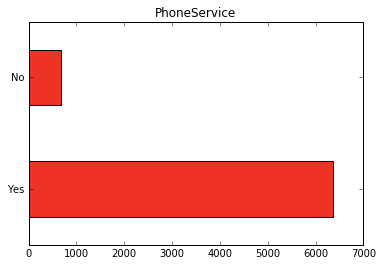

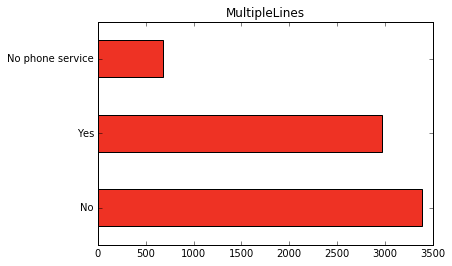

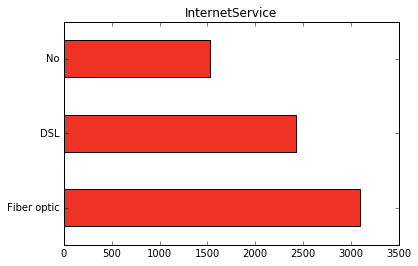

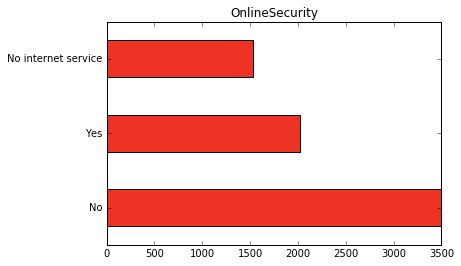

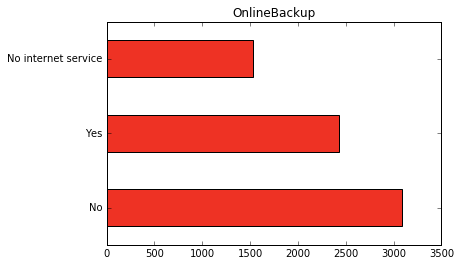

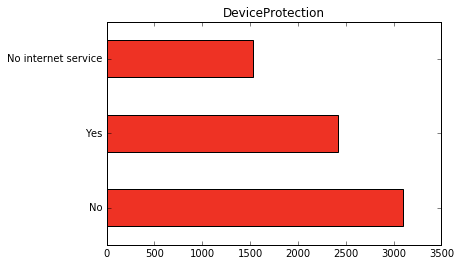

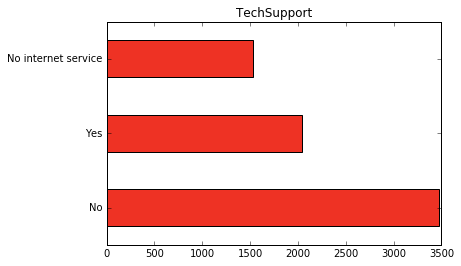

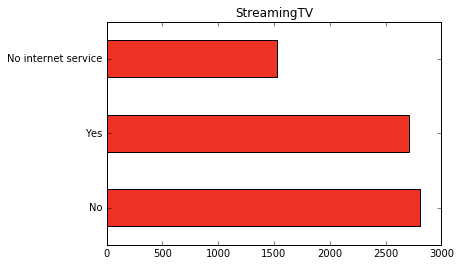

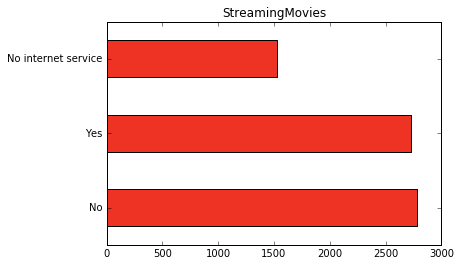

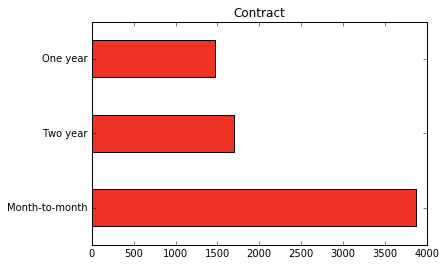

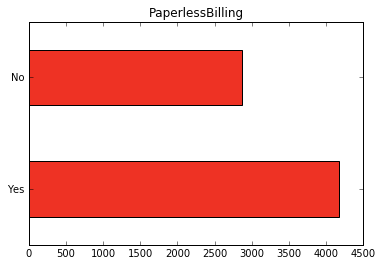

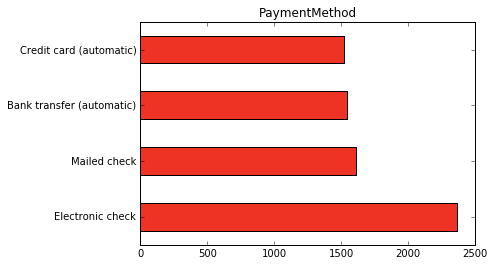

In [115]:
# plot all categorical features
feature_list_new = feature_list.drop('tenure')
for col in feature_list_new [:-3]:
    plt.figure()
    #telco_df[col].value_counts().plot(ax=axes[num,0],kind='bar', subplot=True, color='#FFC222')
    telco_df[col].value_counts().plot(kind='barh', color='#EE3224')
    plt.title(col)
telco_df[col].value_counts().plot(kind='barh', color='#EE3224')

In [120]:
# for each column get the number of people who churn for each category, this will provide 
# insight into what feature levels are tied to churn rates
# what percentage of each category level churned

grouped_test = telco_df['gender'].groupby(telco_df['Churn'])

# set a limit or rule to that say if this person has 3 or more features that would make them likely to churn
# mark them as churned

grouped_test.count()
# create a ranking system of who is likely to churn

Churn
No     5174
Yes    1869
Name: gender, dtype: int64

In [181]:
# telco_df["gender"].sum()

In [182]:
# create a frequency table
gender_table = pd.crosstab(index= telco_df["gender"], columns="count") 
gender_table/gender_table.sum()

col_0,count
gender,
Female,0.495244
Male,0.504756


In [186]:
# Table of churn vs. gender
gender_churn = pd.crosstab(index=telco_df["Churn"], 
                           columns=telco_df["gender"],
                           margins=True)   # Include row and column totals

gender_churn.columns = ["Female","Male","rowtotal"]
gender_churn.index= ["Yes","No","coltotal"]


gender_churn


,Female,Male,rowtotal
Yes,2549,2625,5174
No,939,930,1869
coltotal,3488,3555,7043


In [187]:
#to get the total proportion of counts in each cell, divide the table by the grand total:
gender_churn/gender_churn.ix["coltotal","rowtotal"]

,Female,Male,rowtotal
Yes,0.361920,0.372710,0.73463
No,0.133324,0.132046,0.26537
coltotal,0.495244,0.504756,1.00000


In [188]:
#To get the proportion of counts along each column (in this case, the survival rate within each passenger class)
# divide by the column totals:
gender_churn/gender_churn.ix["coltotal"]

,Female,Male,rowtotal
Yes,0.730791,0.738397,0.73463
No,0.269209,0.261603,0.26537
coltotal,1.000000,1.000000,1.00000


In [191]:
#To get the proportion of counts along each row divide by the row totals. 
#The division operator functions on a row-by-row basis when used on DataFrames by default. 
#In this case we want to divide each column by the rowtotals column. To get division to work on a column
# by column basis, use df.div() with the axis set to 0 (or "index"):
print('Of the people who churned we show how many of them were men compared to women')

gender_churn.div(gender_churn["rowtotal"],
                   axis=0)


Of the people who churned we show how many of them were men compared to women


,Female,Male,rowtotal
Yes,0.492656,0.507344,1.0
No,0.502408,0.497592,1.0
coltotal,0.495244,0.504756,1.0


In [208]:
gender_contract_churn = pd.crosstab(index =telco_df["Churn"], 
                             columns=[telco_df["Contract"],
                                      telco_df["gender"]],
                             margins=True)   # Include row and column totals

gender_contract_churn



Contract Month-to-month       One year      Two year        All
gender           Female  Male   Female Male   Female Male      
Churn                                                          
No                 1083  1137      643  664      823  824  5174
Yes                 842   813       75   91       22   26  1869
All                1925  1950      718  755      845  850  7043

In [223]:
# divide by column totals
gender_contract_churn/gender_contract_churn.ix["All"] 

Contract Month-to-month            One year           Two year            \
gender           Female      Male    Female     Male    Female      Male   
Churn                                                                      
No             0.562597  0.583077  0.895543  0.87947  0.973964  0.969412   
Yes            0.437403  0.416923  0.104457  0.12053  0.026036  0.030588   
All            1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   

Contract      All  
gender             
Churn              
No        0.73463  
Yes       0.26537  
All       1.00000

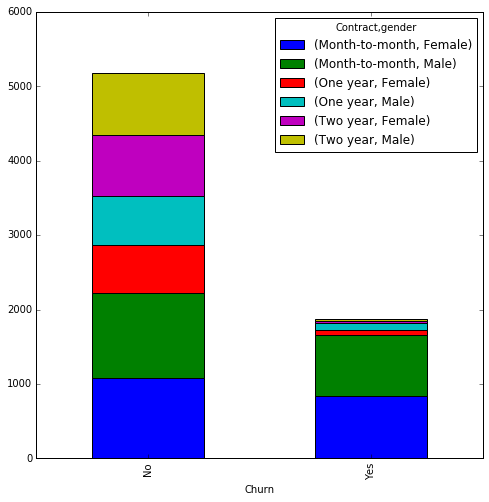

In [225]:
gender_contract= pd.crosstab(index =telco_df["Churn"], 
                             columns=[telco_df["Contract"],
                                      telco_df["gender"]])


gender_contract.plot(kind="bar", 
                 figsize=(8,8),
                 stacked=True)

In [227]:
for col in feature_list_new:
    telco_df['count']
    print telco_df.groupby([col, 'Churn']).size()


gender  Churn
Female  No       2549
        Yes       939
Male    No       2625
        Yes       930
dtype: int64
SeniorCitizen  Churn
0              No       4508
               Yes      1393
1              No        666
               Yes       476
dtype: int64
Partner  Churn
No       No       2441
         Yes      1200
Yes      No       2733
         Yes       669
dtype: int64
Dependents  Churn
No          No       3390
            Yes      1543
Yes         No       1784
            Yes       326
dtype: int64
PhoneService  Churn
No            No        512
              Yes       170
Yes           No       4662
              Yes      1699
dtype: int64
MultipleLines     Churn
No                No       2541
                  Yes       849
No phone service  No        512
                  Yes       170
Yes               No       2121
                  Yes       850
dtype: int64
InternetService  Churn
DSL              No       1962
                 Yes       459
Fiber optic      No  

In [116]:
# looking at the plots, identify features that have the most people
# ie: payment method = electorinic check
# contract: month-to-month
# tech support = No
# anyone who has no internet service (not as dedicated of a customer)
# non senior citizens
# tenure under 24 months
## anyone on a two year contract that has a tenure of 20 - 24 months

In [7]:
# let's get a list of all our most loyal customers by looking at people with
# the longest tenure, 
# highest TotalCharges,
# type of contract


# let's also get a few groupings of people who we think are likely to churn:
# people with month-to-month contracs (Contract)
# people who pay with electronic check or mail check (PaymentMethod)
# people who only have one or none of the following internet services (DeviceProtection,TechSupport,StreamingTV,StreamingMovies)


# lets also get a group of people who we think would be persuaded to stay if they got a coupon
#
